In [22]:
import os 
import cv2
import numpy as np
from torch.utils.data import Dataset , DataLoader , Subset
import glob
from tqdm import tqdm_notebook
import PIL
import copy
from torchvision import models
from torch import nn
from PIL import Image
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import torch
from sklearn.model_selection import StratifiedShuffleSplit

In [23]:
def get_model(num_classes, model_type="rnn"):
    if model_type == "rnn":
        params_model={
            "num_classes": num_classes,
            "dr_rate": 0.1,
            "pretrained" : True,
            "rnn_num_layers": 1,
            "rnn_hidden_size": 100,}
        model = Resnt18Rnn(params_model)        
    else:
        model = models.video.r3d_18(weights=True, progress=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)    
    return model

In [24]:
model_type = "3dcnn"
model = get_model(model_type = model_type, num_classes = 5)
model.eval();

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path2weights = "models/weights_"+model_type+".pt"
 
model.load_state_dict(torch.load(path2weights))
model.to(device);

In [26]:

def get_frames(filename, n_frames= 1):
    frames = []
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_list= np.linspace(0, v_len-1, n_frames+1, dtype=np.int16)
    
    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release()
    return frames, v_len

In [42]:
def transform_frames(frames, model_type="rnn"):
    if model_type == "rnn":
        h, w = 224, 224
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        h, w = 112, 112
        mean = [0.43216, 0.394666, 0.37645]
        std = [0.22803, 0.22145, 0.216989]

    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)]) 

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)    

    if model_type=="3dcnn":
        imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor

Number of Frames Extracted : 16 and length of Video : 62
Details About Vidoe are as Follows : (torch.Size([1, 3, 16, 112, 112]), tensor(-1.8780), tensor(2.8736))
torch.Size([1, 5])
PREDICTED CLASS IS :catch


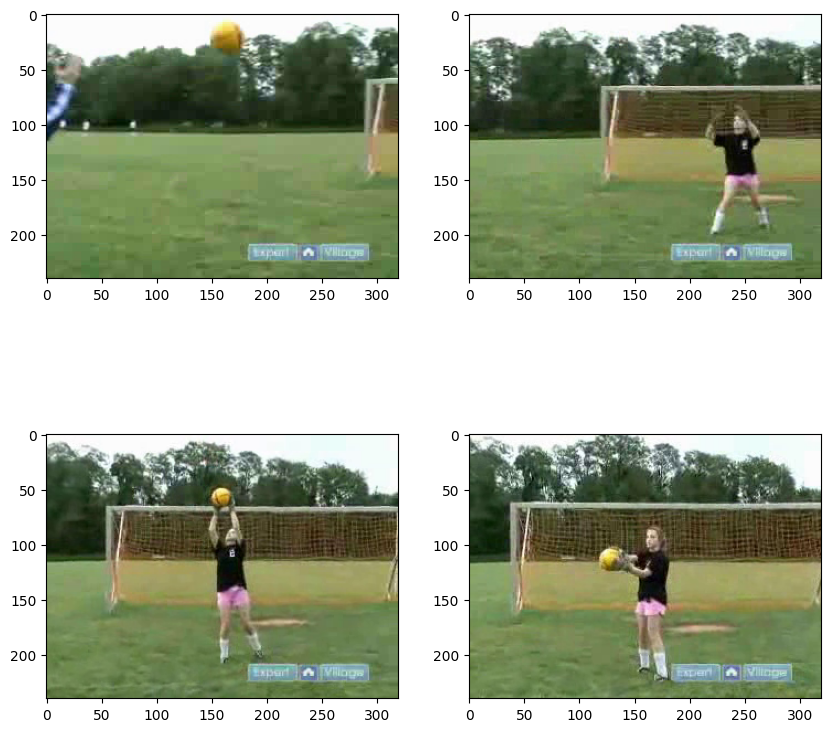

In [53]:
classes = ["brush_hair" , "cartwheel" , "catch" , "chew" , "clap"]
random_classes = random.choice(classes)
random_video = random.choice(os.listdir("HMD51_Data/"+random_classes))
path2vido = "HMD51_Data/"+random_classes +"/" + random_video
frames, v_len = get_frames(path2vido, n_frames=16)
print(f"Number of Frames Extracted : {len(frames)} and length of Video : {v_len}")
plt.figure(figsize=(10,10))
for ii,img in enumerate(frames[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(img)
    
imgs_tensor = transform_frames(frames, model_type)
print(f"Details About Vidoe are as Follows : {imgs_tensor.shape, torch.min(imgs_tensor), torch.max(imgs_tensor)}")

with torch.no_grad():
    out = model(imgs_tensor.to(device)).cpu()
    print(out.shape)
    pred = torch.argmax(out).item()
    print(f"PREDICTED CLASS IS :{classes[pred]}")